# G: Programando clientes `INDI`

En este `notebook` hacemos una introducción simple y burda a como podemos controlar dispositivos astronómicos con `INDI`. Para ello vamos a bajar bastante de nivel: abriremos un `socket` hacia nuestro servidor `INDI` e iremos leyendo / mandando los mensajes de XML que hacen falta para hacerlo funcionar. Algunos enlaces que pueden resultar de interés para seguir mejor estos ejemplos:

+ [Socket Programming in Python (Guide)](https://realpython.com/python-sockets/)

+ [Instalación de `INDI`](https://indilib.org/get-indi.html)

+ [`INDI` whitepaper](http://www.clearskyinstitute.com/INDI/INDI.pdf)

También te puede interesar ver esta [esta introducción a INDI (PDF)](./ficherosAuxiliares/controlDispositivosIndi.pdf)

[![](./ficherosAuxiliares/portadaINDI.jpg)](./ficherosAuxiliares/controlDispositivosIndi.pdf)

## Primer ejemplo: controlando un enfocador simulado

Partimos de la base de que hemos instalado la biblioteca `INDI` y vamos a ejecutar el servidor de `INDI` con un único dispositivo: `indi_simulator_focus` (un simulador de enfocador. Como es un simulador no necesitamos *hardware* ninguno para ejecutar el ejemplo. Podemos abrir un cliente habitual de `INDI` (como el que está integrado en `KStars` para ir comprobando que los cambios que solicitamos al dispositivo efectivamente se llevan a cabo.

```
> indiserver indi_simulator_focus
```

Definimos unas cuantas funciones para simplificar el envio de mensajes y su recepción. No es un código muy elegante puesto que la recepción de mensajes debería hacerse en una hebra (hilo) diferente ([Threading: programación con hilos (I)](https://python-para-impacientes.blogspot.com/2016/12/threading-programacion-con-hilos-i.html)), pero esa es otra historia y debe ser contada en otra ocasión.

In [1]:
#nombreEnfocador = "MyFocuserPro2"
nombreEnfocador = "Focuser Simulator"

In [2]:
import socket
import time
from datetime import datetime

In [3]:
def conectar(host, port):
    global s
    
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)   # Creamos el socket y nos conectamos
    s.connect((host, port))
    s.settimeout(.01)

def mandar(s, comando):      # Manda al socket s un comando
    comando = comando.encode("ASCII")
    
    print(comando)
    
    s.sendall(comando)
    
def recibir(s, wait = 0.1, imprimir=True):  # wait es el tiempo que vamos a esperar leyendo mensajes
    inicio = datetime.now()

    msg = ""
    
    try: 
        msg = s.recv(500000).decode("UTF-8")
    except socket.timeout:
        msg = ""
        
    horaActual = datetime.now()

    while (horaActual - inicio).total_seconds() < wait:   # Espera activa... no es nada elegante :)
        try: 
            msg = msg + s.recv(500000).decode("UTF-8")
        except socket.timeout:
            # no hacemos nada
            msg = msg
            
        horaActual = datetime.now()
        
        time.sleep(0.05)
        
    if imprimir:
        print(msg)
    
    return msg

In [4]:
s=None     # Nuestro socket

host = "127.0.0.1"  # Hostname o IP del servidor de INDI
port = 7624         # Puerto por defecto de INDI


conectar(host, port)

A estas alturas nos hemos conectado al servidor `INDI` pero no hemos recibido nada. Vamos a pedirle que nos envie toda la información sobre dispositivos y sus propiedades que tenga el servidor:

In [5]:
mandar(s, '<getProperties version="1.7" />')

b'<getProperties version="1.7" />'


Y recibimos información a ver que nos dice:

In [6]:
recv = recibir(s, 1)

<defSwitchVector device="Focuser Simulator" name="CONNECTION" label="Connection" group="Main Control" state="Idle" perm="rw" rule="OneOfMany" timeout="60" timestamp="2022-04-29T23:27:41">
    <defSwitch name="CONNECT" label="Connect">
Off
    </defSwitch>
    <defSwitch name="DISCONNECT" label="Disconnect">
On
    </defSwitch>
</defSwitchVector>
<defTextVector device="Focuser Simulator" name="DRIVER_INFO" label="Driver Info" group="Connection" state="Idle" perm="ro" timeout="60" timestamp="2022-04-29T23:27:41">
    <defText name="DRIVER_NAME" label="Name">
Focuser Simulator
    </defText>
    <defText name="DRIVER_EXEC" label="Exec">
indi_simulator_focus
    </defText>
    <defText name="DRIVER_VERSION" label="Version">
1.0
    </defText>
    <defText name="DRIVER_INTERFACE" label="Interface">
8
    </defText>
</defTextVector>
<defSwitchVector device="Focuser Simulator" name="DEBUG" label="Debug" group="Options" state="Idle" perm="rw" rule="OneOfMany" timeout="0" timestamp="2022-04-29T

Lo recibido son todas las propiedades que tiene definidas ese driver en ese momento. En este punto es interesante revisar dichas propiedades y compararlas con la información que nos enseña `KStars`:

![](ficherosAuxiliares/INDI_kstars_01.jpg)

Casi todos los dispositivos `INDI` tienen una propiedad llamada `CONNECTION` que hay que activar para que el dispositivo funcione correctamente. Vamos a pedirle al driver que encienda el enfocador:

In [7]:
mandar(s, f'<newSwitchVector device="{nombreEnfocador}" name="CONNECTION"><oneSwitch name="CONNECT">On</oneSwitch></newSwitchVector>')

b'<newSwitchVector device="Focuser Simulator" name="CONNECTION"><oneSwitch name="CONNECT">On</oneSwitch></newSwitchVector>'


In [8]:
recv = recibir(s, 1)

<setSwitchVector device="Focuser Simulator" name="CONNECTION" state="Ok" timeout="60" timestamp="2022-04-29T23:27:49">
    <oneSwitch name="CONNECT">
On
    </oneSwitch>
    <oneSwitch name="DISCONNECT">
Off
    </oneSwitch>
</setSwitchVector>
<defSwitchVector device="Focuser Simulator" name="FOCUS_MOTION" label="Direction" group="Main Control" state="Ok" perm="rw" rule="OneOfMany" timeout="60" timestamp="2022-04-29T23:27:49">
    <defSwitch name="FOCUS_INWARD" label="Focus In">
On
    </defSwitch>
    <defSwitch name="FOCUS_OUTWARD" label="Focus Out">
Off
    </defSwitch>
</defSwitchVector>
<defNumberVector device="Focuser Simulator" name="FOCUS_SPEED" label="Speed" group="Main Control" state="Ok" perm="rw" timeout="60" timestamp="2022-04-29T23:27:49">
    <defNumber name="FOCUS_SPEED_VALUE" label="Focus Speed" format="%3.0f" min="1" max="5" step="1">
1
    </defNumber>
</defNumberVector>
<defNumberVector device="Focuser Simulator" name="REL_FOCUS_POSITION" label="Relative Position" g

Tras conectarse hemos recibido la confirmación de que se ha conectado (la propiedad `CONNECTION` tiene su campo `CONNECT` a `ON` (antes estaba a `OFF`) junto con otras muchas propiedades que tenemos disponibles:

![](ficherosAuxiliares/INDI_kstars_02.jpg)

Para finalizar este ejemplo vamos a pedirle al enfocador que vaya a la posición absoluta `2000` (la inicial es `50000`):

In [11]:
mandar(s, f'<newNumberVector device="{nombreEnfocador}" name="ABS_FOCUS_POSITION"><oneNumber name="FOCUS_ABSOLUTE_POSITION">100000</oneNumber></newNumberVector>')

b'<newNumberVector device="Focuser Simulator" name="ABS_FOCUS_POSITION"><oneNumber name="FOCUS_ABSOLUTE_POSITION">100000</oneNumber></newNumberVector>'


Recibimos los mensajes (dejamos 5 prudentes segundos para asegurarnos que el enfocador ha tenido tiempo de llegar a la posición deseada):

In [13]:
recv = recibir(s, 5)

<setNumberVector device="Focuser Simulator" name="FWHM" state="Idle" timeout="60" timestamp="2022-04-29T23:28:31">
    <oneNumber name="SIM_FWHM">
93.75
    </oneNumber>
</setNumberVector>
<message device="Focuser Simulator" timestamp="2022-04-29T23:28:31" message="[INFO] Focuser moved to position 100000"/>
<setNumberVector device="Focuser Simulator" name="ABS_FOCUS_POSITION" state="Ok" timeout="60" timestamp="2022-04-29T23:28:31">
    <oneNumber name="FOCUS_ABSOLUTE_POSITION">
100000
    </oneNumber>
</setNumberVector>



Efectivamente hemos recibido (además de otra información) una nueva posición absoluta de `100000`. Podemos comprobar que en `KStars` también se refleja dicho cambio:

![](ficherosAuxiliares/INDI_kstars_03.jpg)

Por último cerraremos el `socket` para desconectarnos del servidor `INDI`:

In [14]:
s.close()

## Controlando una CCD simulada y una montura (también simulada)

Vamos a hacer otro ejemplo para capturar una imagen (`FITS`) de una cámara virtual simulada. El simulador puede mostrar estrellas "realistas" si instalamos el `GSC` (*General Star Catalog*). En Linux:

```
> sudo apt install gsc 
```

Para ello lanzaremos el servidor `INDI` con el driver `indi_simulator_ccd` y el driver `indi_simulator_telescope`:

```
> indiserver indi_simulator_ccd indi_simulator_telescope
```

In [15]:
import socket
from pprint import pprint
import time
from datetime import datetime
import regex as re

Conectamos al servidor `INDI`:

In [16]:
s = None
   
conectar("127.0.0.1", 7624)

nombreCamara = "CCD Simulator"
nombreMontura = "Telescope Simulator"

In [ ]:
# mandar(s, '<getProperties version="1.7" />')

In [ ]:
# recv = recibir(s, 1)

Conectamos la cámara y la montura:

In [17]:
mandar(s, f'<newSwitchVector device="{nombreCamara}" name="CONNECTION"><oneSwitch name="CONNECT">On</oneSwitch></newSwitchVector>')

mandar(s, f'<newSwitchVector device="{nombreMontura}" name="CONNECTION"><oneSwitch name="CONNECT">On</oneSwitch></newSwitchVector>')

b'<newSwitchVector device="CCD Simulator" name="CONNECTION"><oneSwitch name="CONNECT">On</oneSwitch></newSwitchVector>'
b'<newSwitchVector device="Telescope Simulator" name="CONNECTION"><oneSwitch name="CONNECT">On</oneSwitch></newSwitchVector>'


In [ ]:
# recv = recibir(s, 1)

Activamos la recepción de `BLOBs` (objetos binarios, en este caso y casi siempre imágenes `FITS`:

In [18]:
mandar(s, f'<enableBLOB device="{nombreCamara}">Only</enableBLOB>"')

b'<enableBLOB device="CCD Simulator">Only</enableBLOB>"'


In [ ]:
# recv = recibir(s, 1)

Movemos la montura a Sirio:

In [19]:
mandar(s, f'<newNumberVector device="{nombreMontura}" name="EQUATORIAL_EOD_COORD"><oneNumber name="RA">6.7685230037972683448</oneNumber><oneNumber name="DEC">-16.746465419192418267</oneNumber></newNumberVector>')

b'<newNumberVector device="Telescope Simulator" name="EQUATORIAL_EOD_COORD"><oneNumber name="RA">6.7685230037972683448</oneNumber><oneNumber name="DEC">-16.746465419192418267</oneNumber></newNumberVector>'


In [ ]:
# recv = recibir(s, 1)

Tomamos una exposición de 2 segundos y esperamos a que mande los resultados. Cuidado si imprimimos que son varios megas y `Jupyter-Lab` se puede quejar:

In [20]:
mandar(s, f'<newNumberVector device="{nombreCamara}" name="CCD_EXPOSURE"><oneNumber name="CCD_EXPOSURE_VALUE">2.0</oneNumber></newNumberVector>')
recv = recibir(s, 3, imprimir=False)

#print(recv[0:1000])
#print(recv[-1000:])

b'<newNumberVector device="CCD Simulator" name="CCD_EXPOSURE"><oneNumber name="CCD_EXPOSURE_VALUE">2.0</oneNumber></newNumberVector>'


Buscamos exactamente los datos de la imagen que vienen codificados como una cadena en BASE64 dentro de un elemento `<oneBLOB> ... </oneBLOB>`:

In [21]:
datosBLOB = re.search(r'.*<oneBLOB(.*)>(.*)</oneBLOB>.*', recv, flags=re.DOTALL).group(2)

#print(datosBLOB[0:1000])
#print(len(datosBLOB))
#print(datosBLOB[-10000:])

Decodificamos los datos a binario y guardamos la imagen (directamente los datos binarios son los datos del fichero `FITS`):

In [22]:
import base64

message_bytes = base64.b64decode(datosBLOB)

f = open("salidas/capturaINDI.fit", "wb")

f.write(message_bytes)

f.close()

Cerramos el `socket`:

In [23]:
s.close()

Mostramos la imagen:

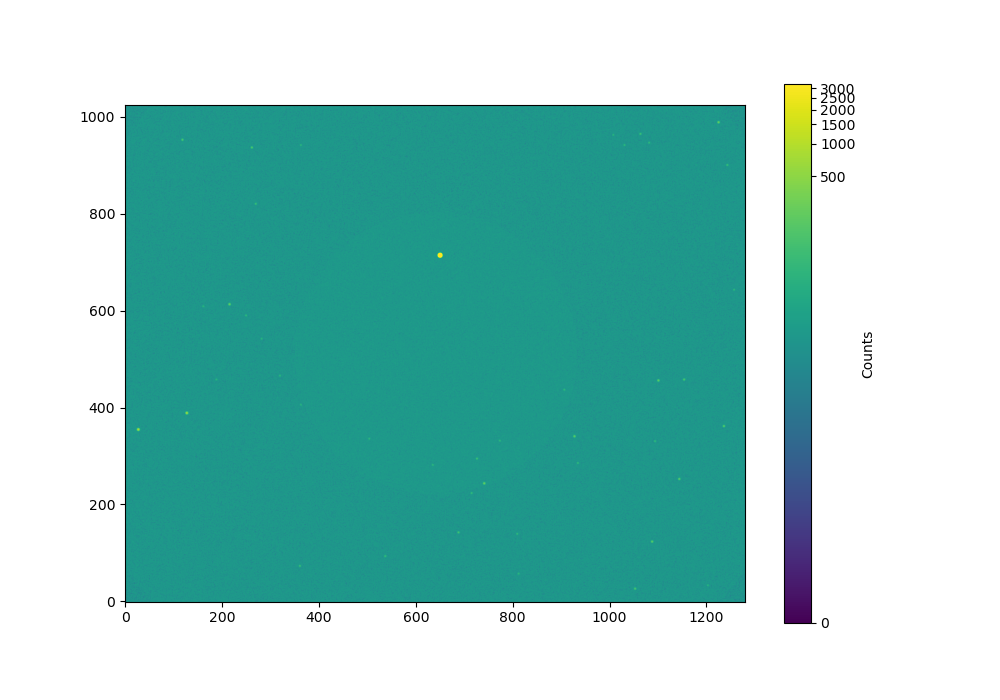

In [24]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import matplotlib.colors as colors

hdul = fits.open("salidas/capturaINDI.fit")
data = hdul[0].data
fig = plt.figure("matrix", figsize=[10, 7])

image = plt.imshow(data, norm=colors.PowerNorm(gamma=.1, vmin=np.min(data), vmax=np.max(data)/20), origin='lower')
plt.colorbar(label='Counts')

## Capturando imágenes de una cámara real: ZWO ASI174MM-Cool

Con casi el mismo código anterior (obviando el tema de la montura) podemos disparar una cámara real. Vamos a lanzar el servidor de `INDI` con el driver correspondiente:

```
> indiserver indi_asi_ccd
```

In [25]:
import socket
from pprint import pprint
import time
from datetime import datetime
import regex as re

s = None
   
conectar("127.0.0.1", 7624)

nombreCamara = "ZWO CCD ASI174MM-Cool"

mandar(s, f'<newSwitchVector device="{nombreCamara}" name="CONNECTION"><oneSwitch name="CONNECT">On</oneSwitch></newSwitchVector>')

mandar(s, f'<enableBLOB device="{nombreCamara}">Only</enableBLOB>"')

mandar(s, f'<newNumberVector device="{nombreCamara}" name="CCD_EXPOSURE"><oneNumber name="CCD_EXPOSURE_VALUE">2.0</oneNumber></newNumberVector>')

recv = recibir(s, 4, imprimir=False)

datosBLOB = re.search(r'.*<oneBLOB(.*)>(.*)</oneBLOB>.*', recv, flags=re.DOTALL).group(2)

import base64

message_bytes = base64.b64decode(datosBLOB)

f = open("salidas/capturaINDI_ZWO.fit", "wb")

f.write(message_bytes)

f.close()

b'<newSwitchVector device="ZWO CCD ASI174MM-Cool" name="CONNECTION"><oneSwitch name="CONNECT">On</oneSwitch></newSwitchVector>'
b'<enableBLOB device="ZWO CCD ASI174MM-Cool">Only</enableBLOB>"'
b'<newNumberVector device="ZWO CCD ASI174MM-Cool" name="CCD_EXPOSURE"><oneNumber name="CCD_EXPOSURE_VALUE">2.0</oneNumber></newNumberVector>'
